In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.stats import multivariate_normal
import datetime
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()

In [2]:
URL = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'

In [3]:
COUNTRY = 'Russia'
DATE_START = '2020-03-03'
TARGET = 'total_cases'

In [4]:
df = pd.read_csv(URL)

In [5]:
df['date'] = pd.to_datetime(df['date'])

df = df[df['date'] >= DATE_START]
df = df[df['location'] == COUNTRY]

df['days'] = (df['date'] - df['date'].min()).dt.days + 1

df.reset_index(drop=True, inplace=True)

In [6]:
train = df[df['days'] <= 50]
test = df[df['days'] > 50].reset_index(drop=True)

In [7]:
print(train.shape, test.shape)

(50, 68) (1052, 68)


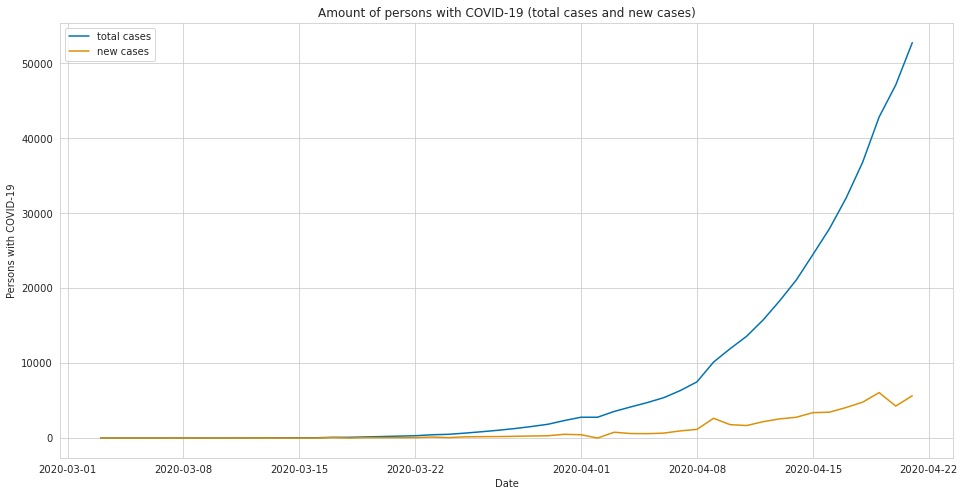

In [8]:
first_days = 50
sub_df = df[df['days'] <= first_days]
plt.rcParams['figure.figsize'] = (16, 8)

fig, ax = plt.subplots()

ax.plot(sub_df['date'], sub_df['total_cases'], label='total cases')
ax.plot(sub_df['date'], sub_df['new_cases'], label='new cases')

plt.title('Amount of persons with COVID-19 (total cases and new cases)')
plt.xlabel('Date')
plt.ylabel('Persons with COVID-19')
plt.legend()
# plt.show()

# 2.a

Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.

In [9]:
model = LinearRegression()

In [10]:
X = train['days'].values.reshape(-1, 1)
y = np.log(train[TARGET].values)
model.fit(X, y)

LinearRegression()

In [11]:
[w1], w0 = model.coef_, model.intercept_
print(w0, w1)

0.9793129090560422 0.21410636658252818


In [12]:
train['predicted'] = train['days'] * w1  + w0

/home/lolvista/anaconda3/envs/.made/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


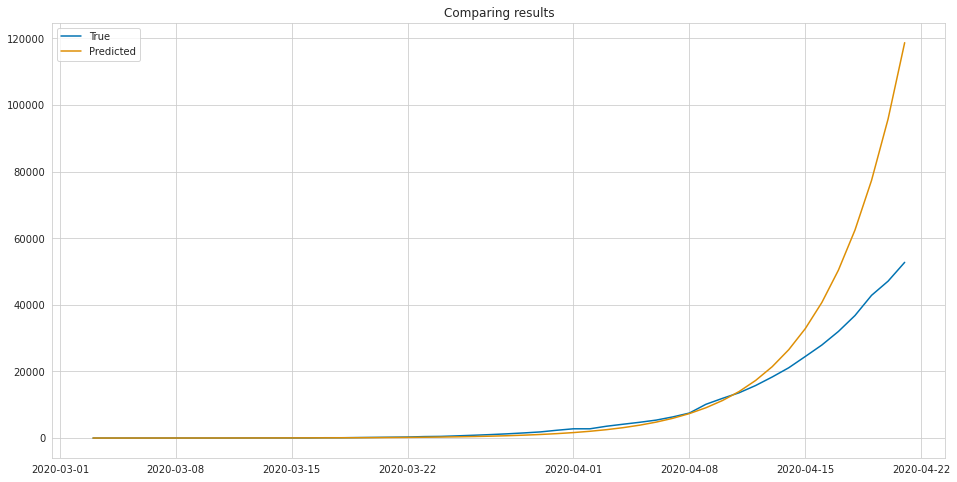

In [13]:
fig, ax = plt.subplots()
first_days = 100
ax.plot(train['date'], train[TARGET], label='True')
ax.plot(train['date'], np.exp(train['predicted']), label='Predicted')
plt.title('Comparing results')
plt.legend()

# 2.b

Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

In [14]:
var = np.std(train['predicted'] - np.log(train[TARGET]))
print(var)

0.4498899109116322


In [15]:
def bayesian_update(mu, sigma, x, y, sigma_noise=var):
    x_matrix = np.array([[1, x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (var ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (var ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [16]:
n_features = 2
weight = 100

mu_prior = np.zeros(n_features)
sigma_prior = np.eye(n_features) * weight
print(f'prior mu: {mu_prior}\nprior sigma: {sigma_prior}')

prior mu: [0. 0.]
prior sigma: [[100.   0.]
 [  0. 100.]]


In [17]:
def plot_heatmap(cur_mu, cur_sigma, xmin, xmax, ymin, ymax, N = 200):
    
    X_ = np.linspace(xmin, xmax, N)
    Y_ = np.linspace(ymin, ymax, N)
    X_, Y_ = np.meshgrid(X_, Y_)

    pos = np.empty(X_.shape + (2,))
    pos[:, :, 0] = X_
    pos[:, :, 1] = Y_
    Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
    plt.figure(figsize = (5, 5), dpi = 100)
    plt.title('Распределение параметров модели')
    plt.pcolormesh(X_, Y_, Z, cmap=plt.cm.jet)

/home/lolvista/anaconda3/envs/.made/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]


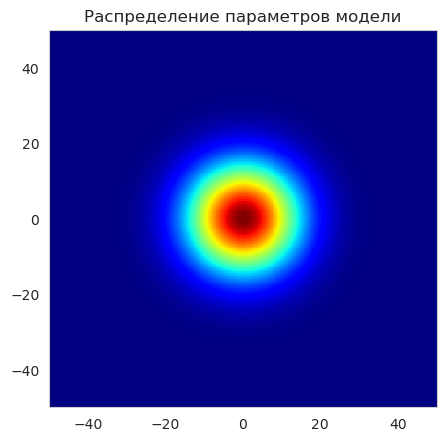

In [18]:
limit = 50
plot_heatmap(mu_prior, sigma_prior, xmin = -limit, xmax = limit, ymin = -limit, ymax = limit)


/home/lolvista/anaconda3/envs/.made/lib/python3.6/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]


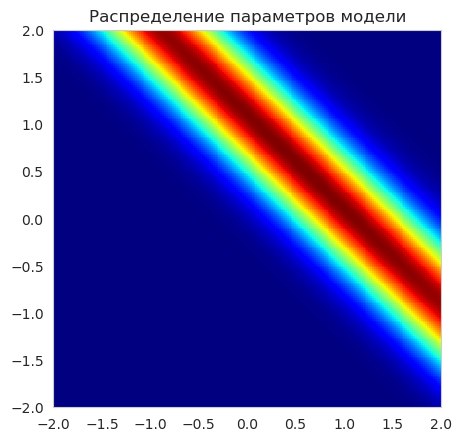

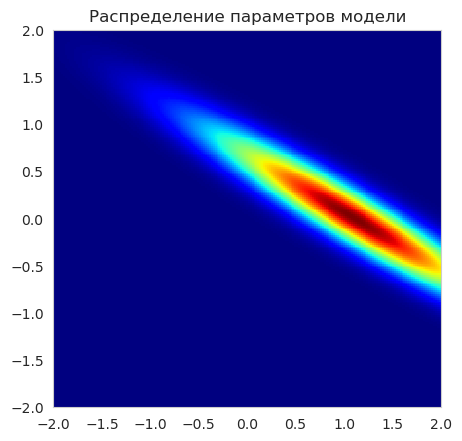

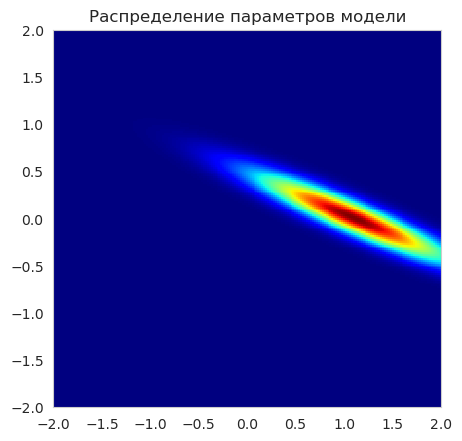

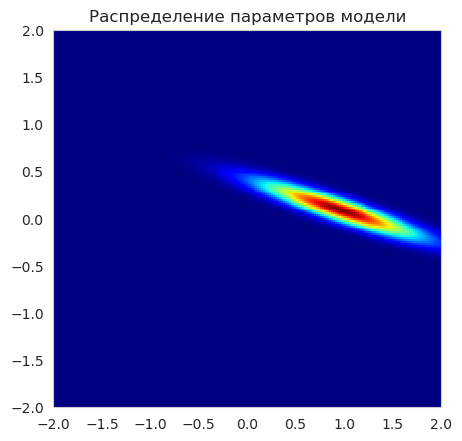

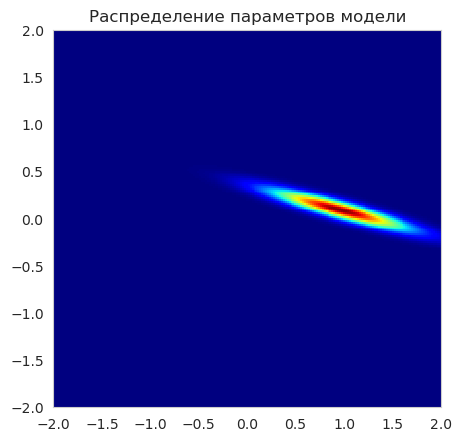

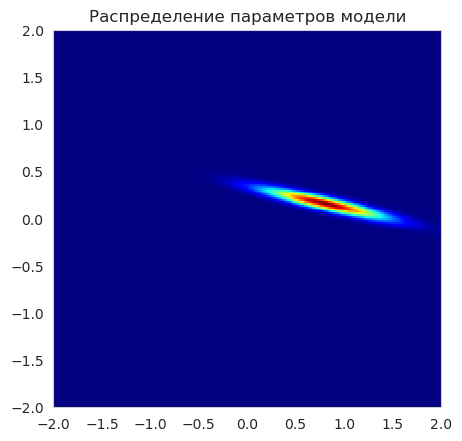

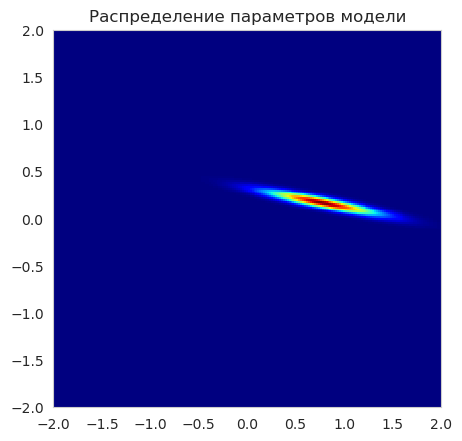

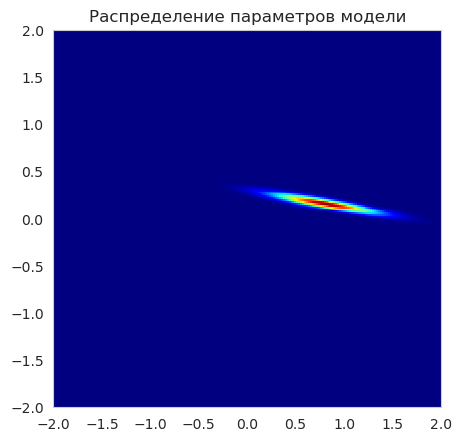

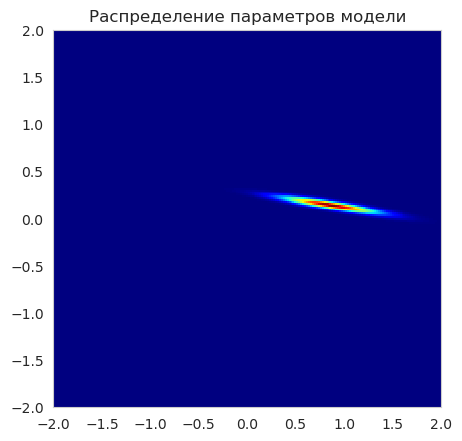

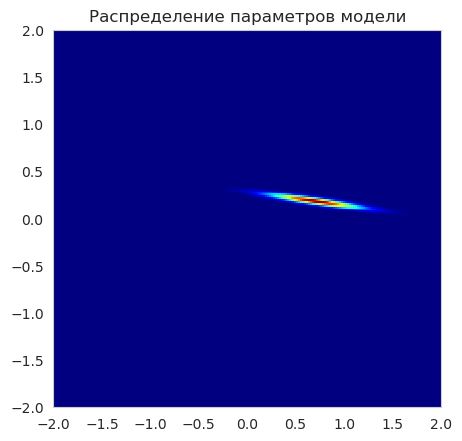

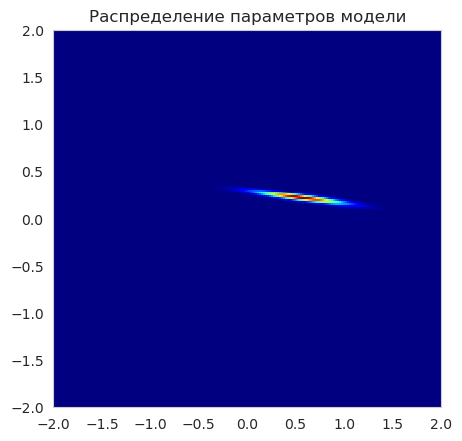

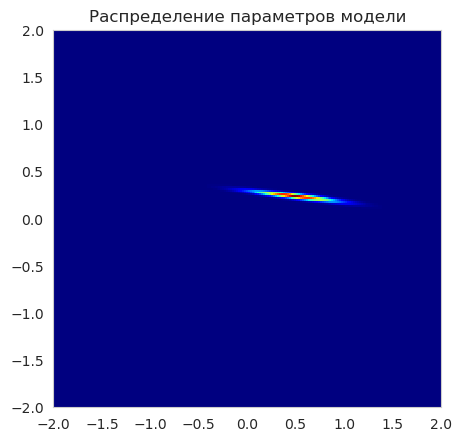

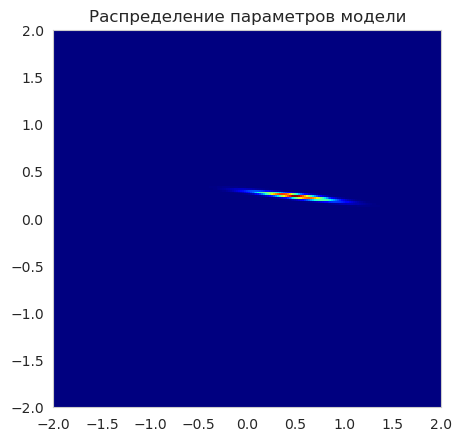

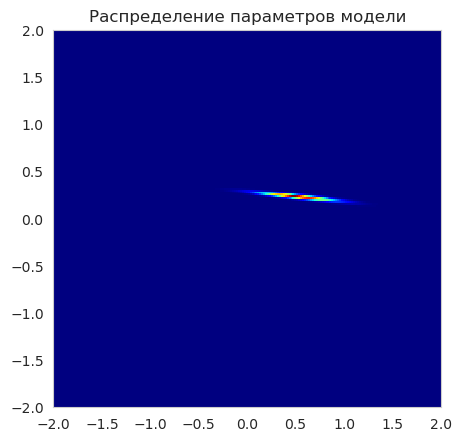

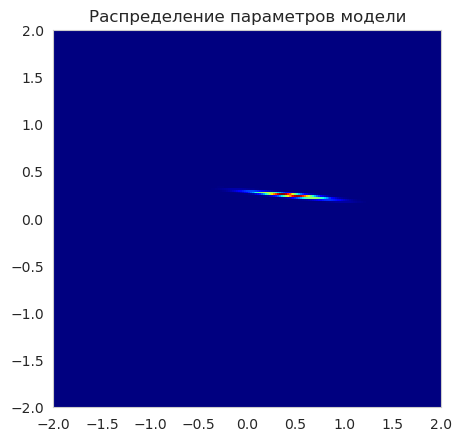

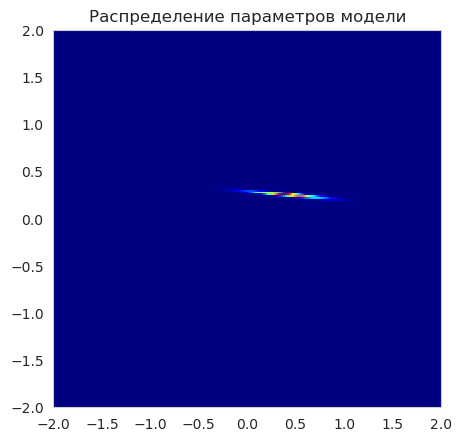

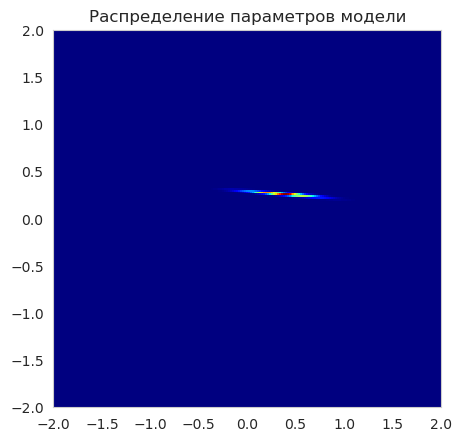

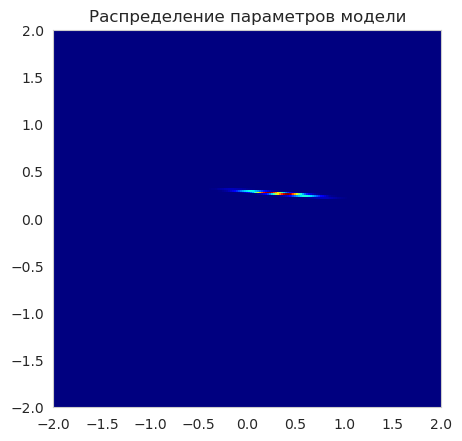

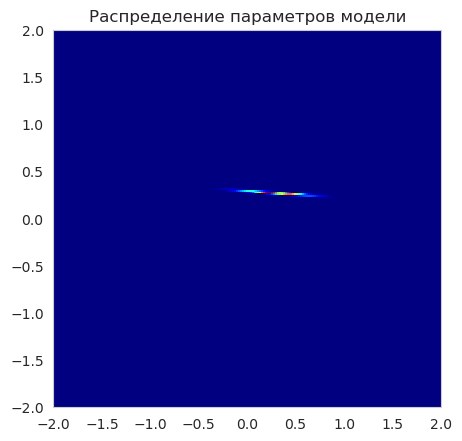

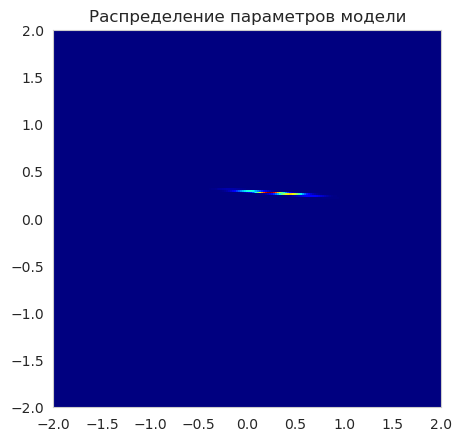

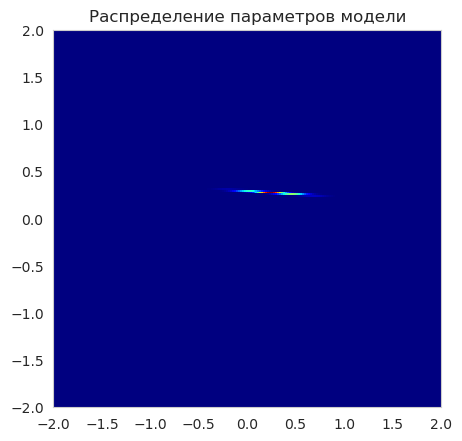

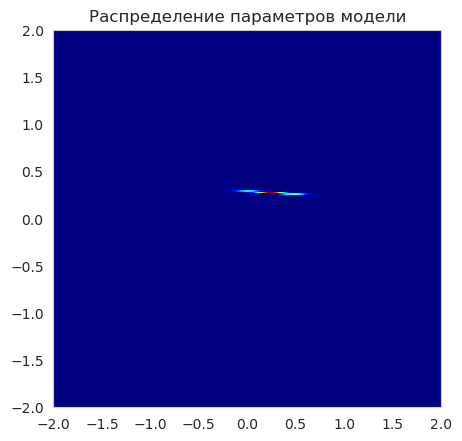

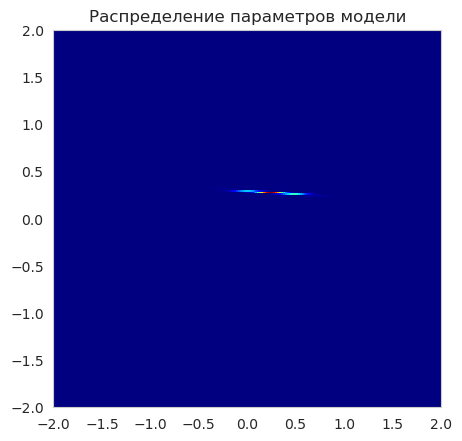

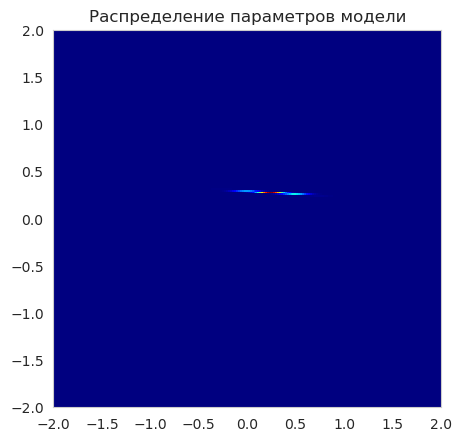

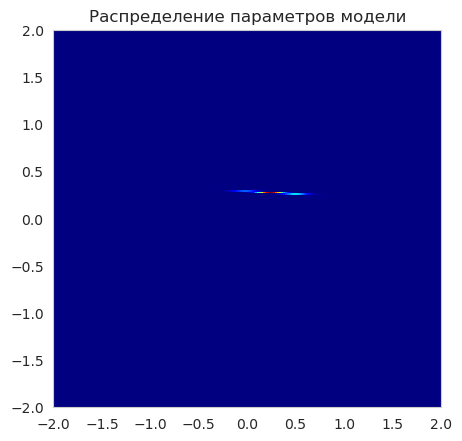

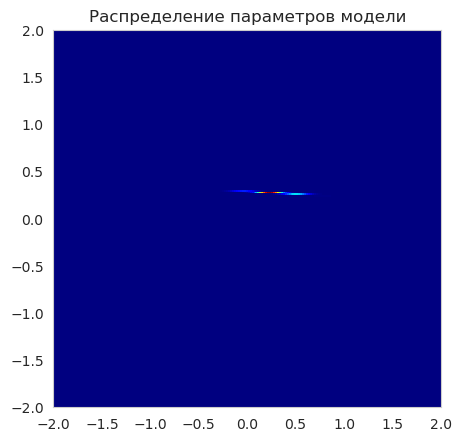

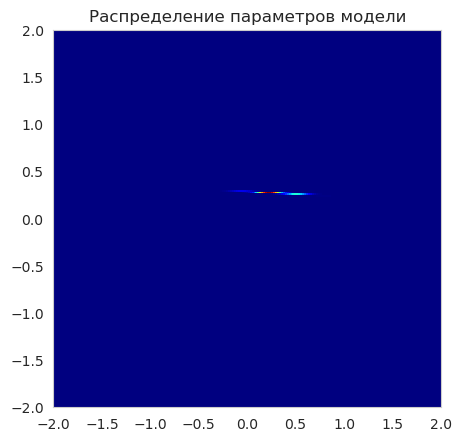

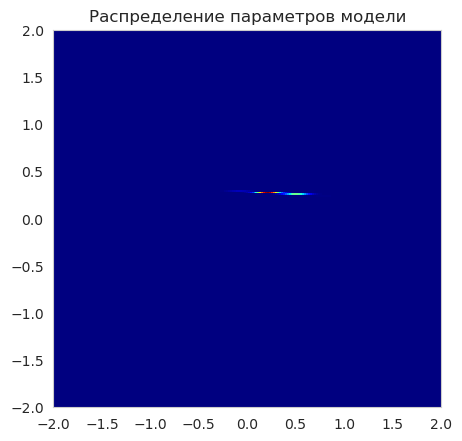

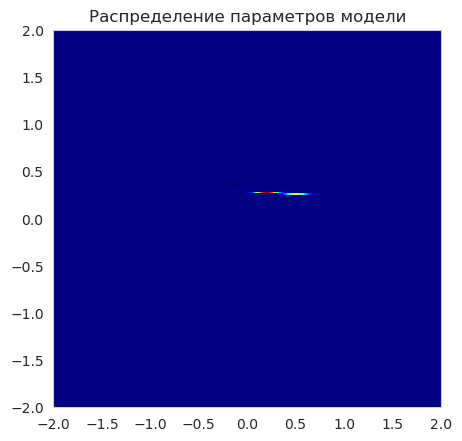

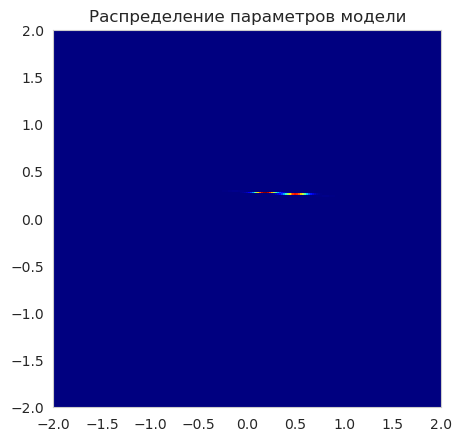

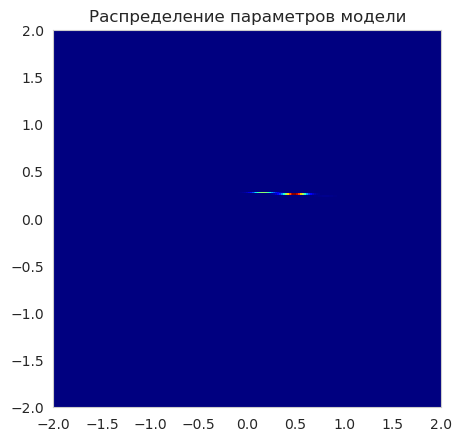

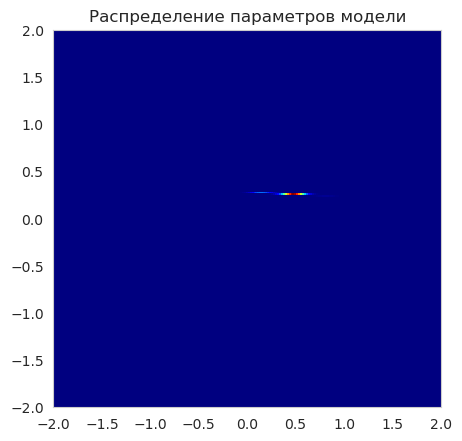

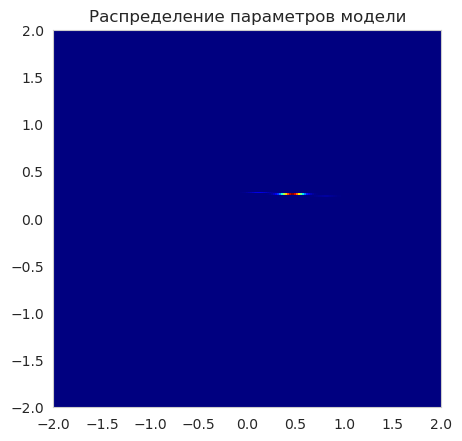

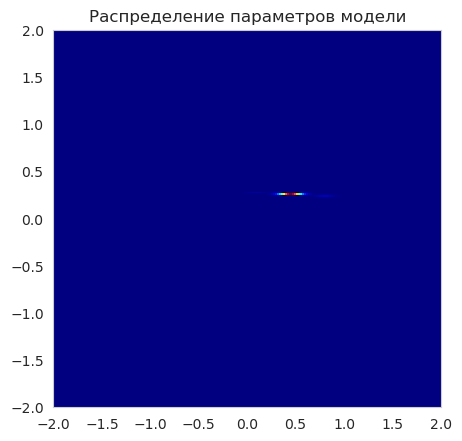

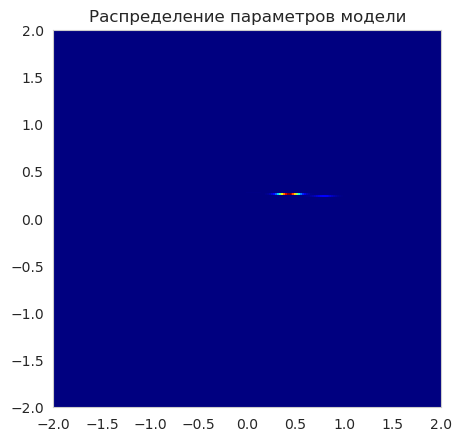

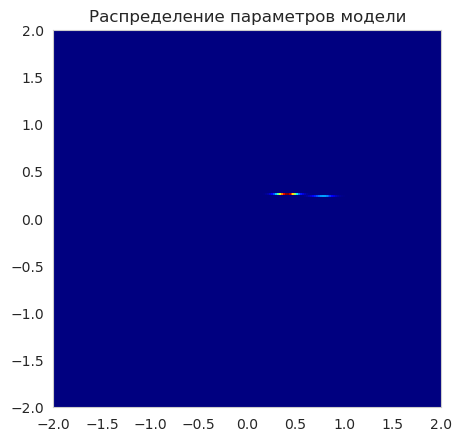

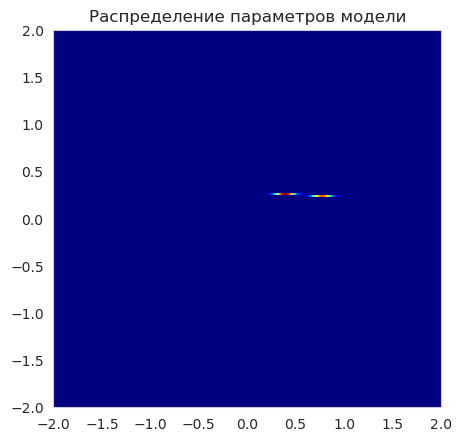

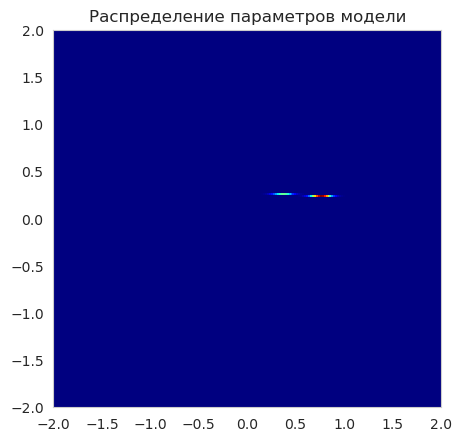

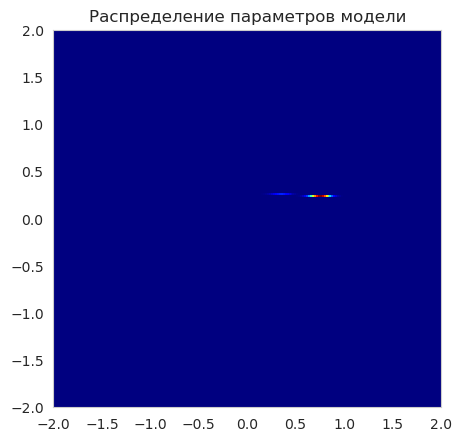

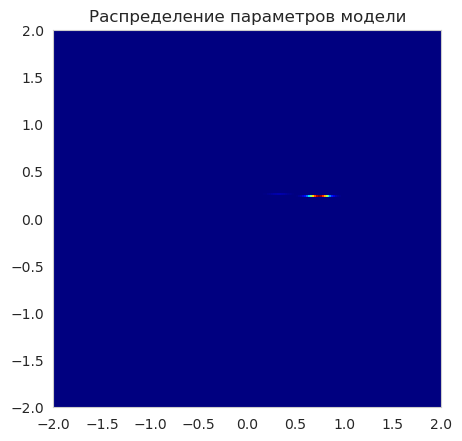

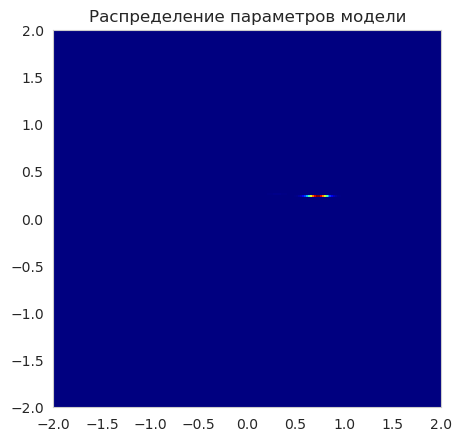

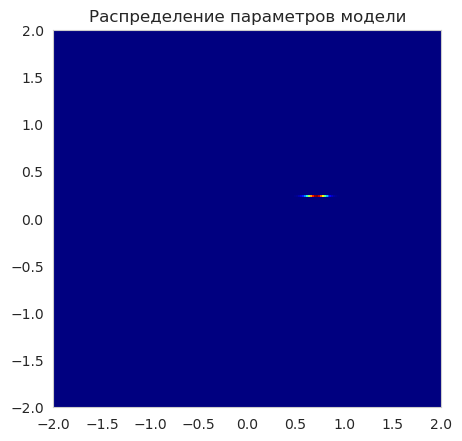

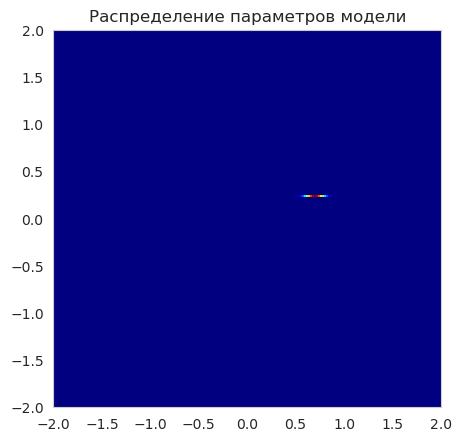

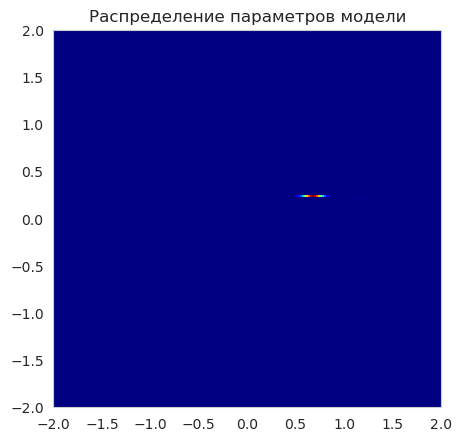

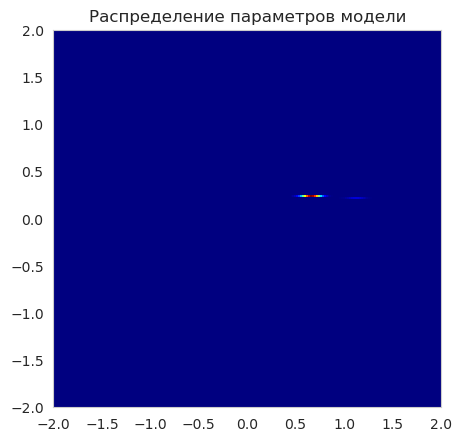

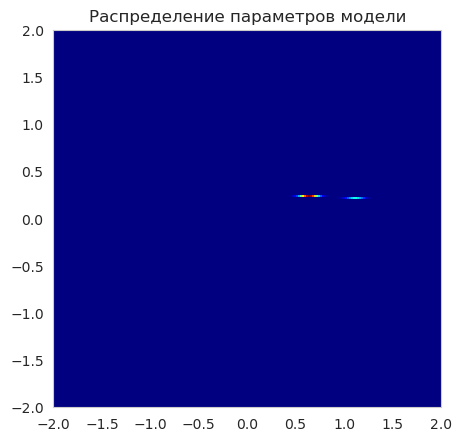

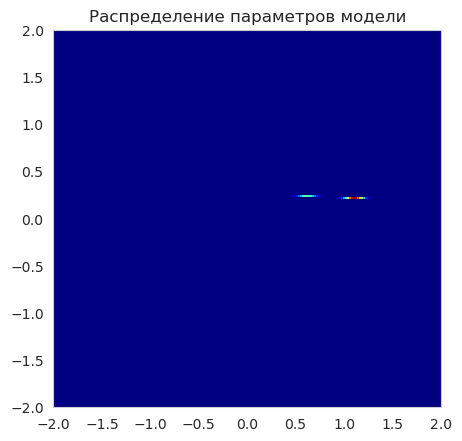

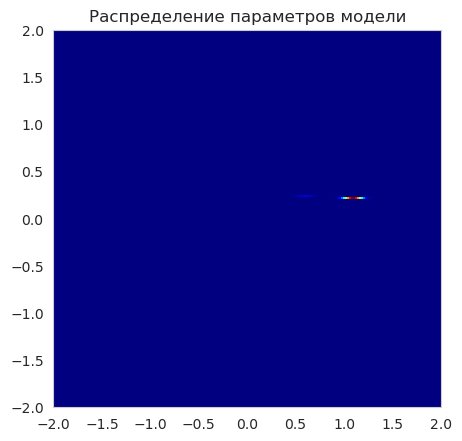

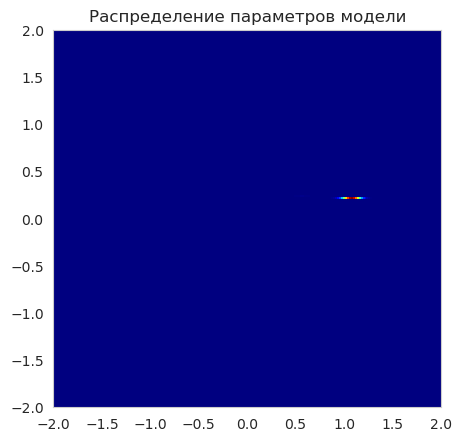

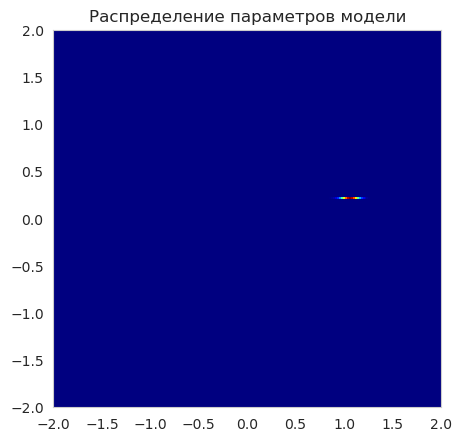

In [19]:
limit = 2

params = [mu_prior]
cur_mu = mu_prior
cur_sigma = sigma_prior

for day, total in zip(np.arange(1, 51, 1), train[TARGET].values):
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, day, np.log(total), sigma_noise=var)
    plot_heatmap(cur_mu, cur_sigma, xmin = -limit, xmax = limit, ymin = -limit, ymax = limit)
    plt.show()
    params.append(cur_mu)


In [20]:
params = list(zip(*params))

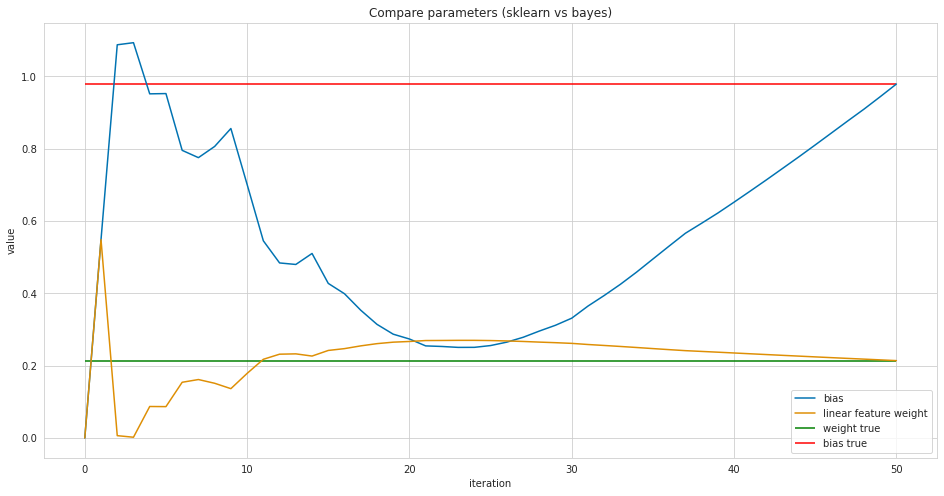

In [21]:
plt.xlabel('iteration')
plt.ylabel('value')
plt.plot(params[0], label='bias')
plt.plot(params[1], label='linear feature weight')
plt.hlines(y=model.coef_, xmin=0, xmax=50, label='weight true', colors='g')
plt.hlines(y=model.intercept_, xmin=0, xmax=50, label='bias true', color='r')
plt.title('Compare parameters (sklearn vs bayes)')
plt.legend();

In [22]:
print('Aposterior Distribution: ', cur_mu)


Aposterior Distribution:  [0.97915057 0.21411118]


In [23]:
print('Sklearn weights: ', model.intercept_, model.coef_[0])

Sklearn weights:  0.9793129090560422 0.21410636658252818


# 2.c

Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).

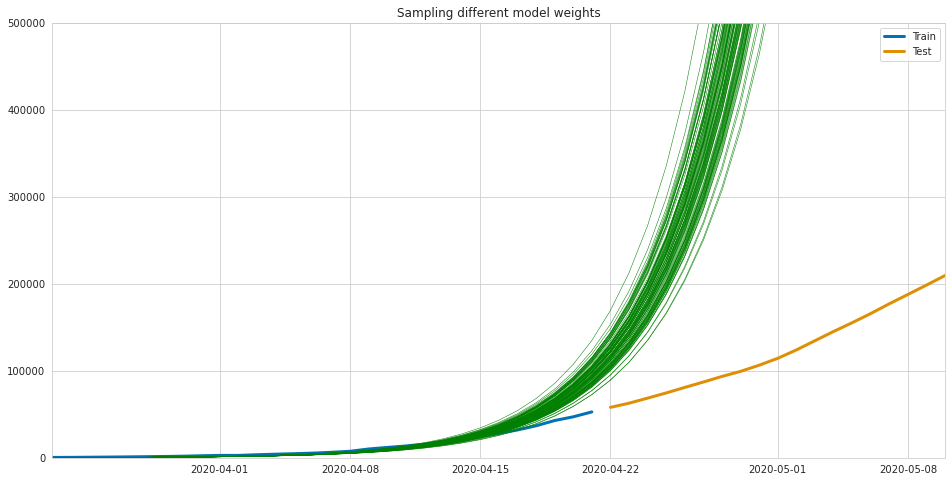

In [24]:
plt.plot(train['date'], train[TARGET], linewidth=3, label='Train')
plt.plot(test['date'], test[TARGET], linewidth=3, label='Test')


n_weights = 100
n_days = 100
weights = np.random.multivariate_normal(cur_mu, cur_sigma, size=n_weights)
X = np.arange(n_days)

for intersect, coeff in weights:
    plt.plot(df[:n_days]['date'], np.exp(X * coeff + intersect), color='g', linewidth=0.5)


plt.xlim(left=datetime.date(2020,3,23), right=datetime.date(2020,5,10))
plt.ylim(bottom=0, top=5e5)

plt.title('Sampling different model weights')
plt.legend()


In [25]:
dates = ['2020-05-01', '2020-06-01', '2020-09-01']

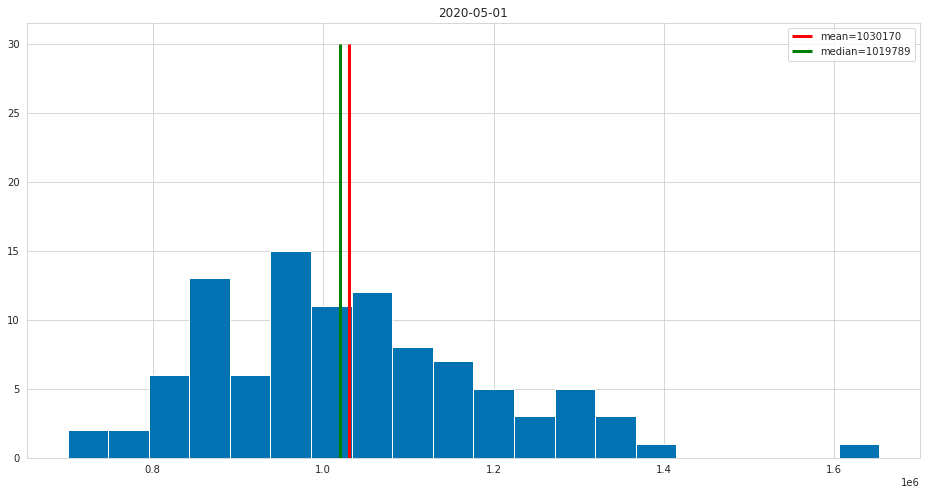

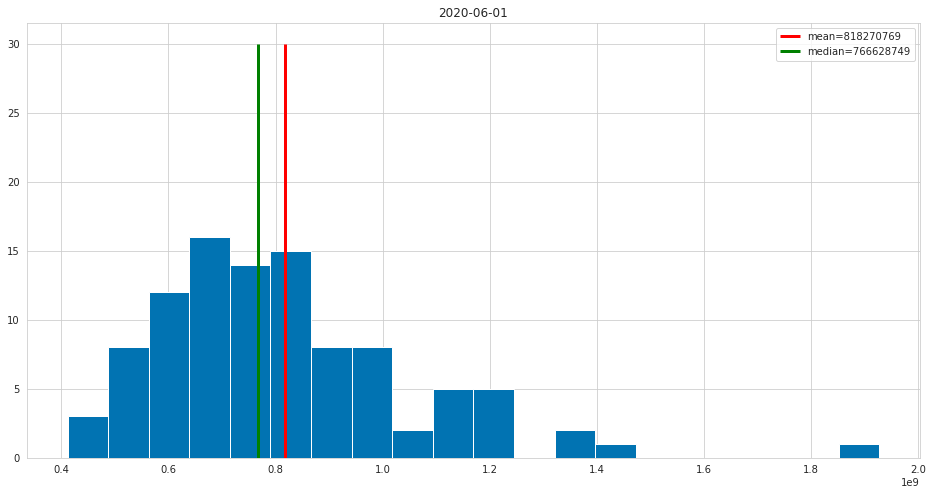

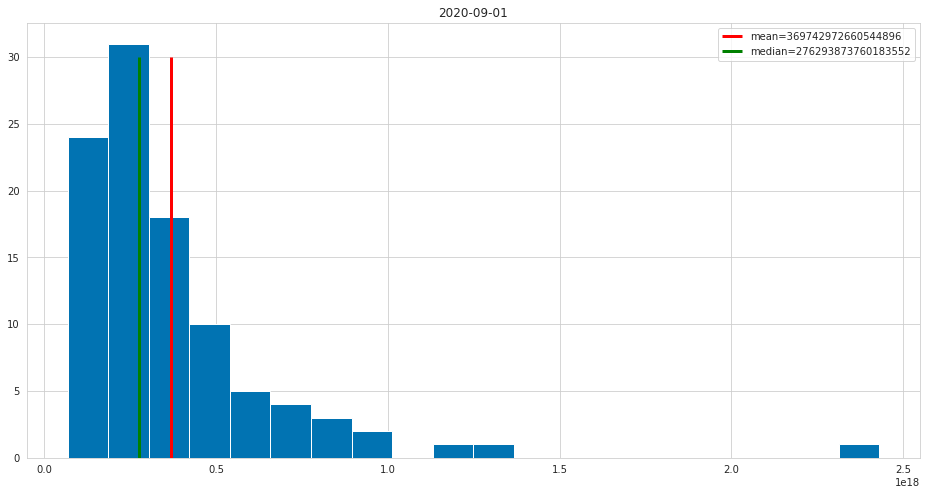

In [26]:
means = []
medians = []

for date in dates:
    date_num = df[df['date'] == date]['days'].values[0]
    pred = np.exp(date_num * weights[:,1] + weights[:, 0])
    plt.hist(pred, bins=20)
    plt.title(date)
    
    mean = int(np.mean(pred))
    median = int(np.median(pred))
    means.append(mean)
    medians.append(median)
    plt.vlines(pred.mean(), ymin=0, ymax=30, color='r', label=f'mean={mean}', linewidth=3)
    plt.vlines(np.median(pred), ymin=0, ymax=30, color='g', label=f'median={median}', linewidth=3)

    plt.legend()
    plt.show()

In [27]:
for date, mean, median in zip(dates, means, medians):
    true_val = int(test[test['date'] == date][TARGET].values[0])
    print(f"Date: {date}, mean: {mean}, median: {median}, true: {true_val}")

Date: 2020-05-01, mean: 1030170, median: 1019789, true: 114431
Date: 2020-06-01, mean: 818270769, median: 766628749, true: 414878
Date: 2020-09-01, mean: 369742972660544896, median: 276293873760183552, true: 1000048


# 3

Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:


Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от t.


# 3.a

Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии

1. Количество всего заболевших состоит из суммы новых заболевших рассматриваемого периода
2. Логично перейти от функции распределения к логарифму плотности
3. Теперь модель будет предсказывать количество новых заболевших (теперь используем квадратичную функцию), а переход к рассматриваемой метрике (количество всего заболевших) будет осуществляться за счет кумулятивной суммы предсказанных значений

# 3.b

Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.

In [28]:
new_target = 'new_cases'

#prevent log(0)
padding = 1

In [29]:
model_2 = LinearRegression()
X = train['days']
X = np.array(list(zip(X, X**2)))
ln_Y = np.log(train[new_target] + padding).values.reshape(-1, 1)
model_2.fit(X,ln_Y)

LinearRegression()

In [30]:
[[w1, w2]], [w0] = model_2.coef_, model_2.intercept_

In [31]:
print(w0, w1, w2)

-0.8728126907321823 0.2428307749211234 -0.0009164937957281633


In [32]:
X = train['days']
prediction = X * w1 + X ** 2 * w2 + w0
train['cumulative_predicted'] = np.cumsum(np.exp(prediction))

/home/lolvista/anaconda3/envs/.made/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


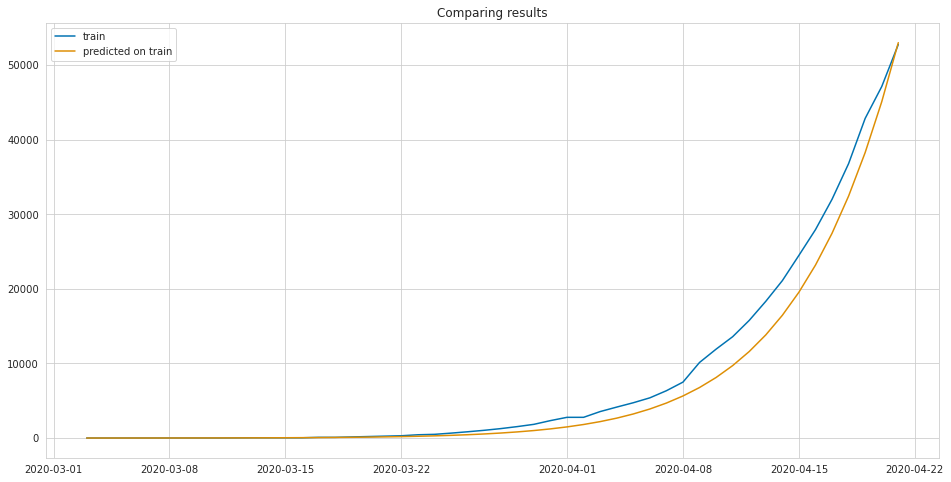

In [33]:
fig, ax = plt.subplots()
first_days = 100
ax.plot(train['date'], train[TARGET], label='train')
ax.plot(train['date'], train['cumulative_predicted'], label='predicted on train')


#uncomment to see predictions on test
# days_test = test['days'].values
# pred_test = days_test * w1 + days_test ** 2 * w2 + w0

# ax.plot(test['date'], test[TARGET], label='test')
# ax.plot(test['date'], np.cumsum(np.exp(pred_test)), label='predicted on test')

plt.title('Comparing results')
plt.legend()

In [34]:
var = np.std(train['predicted'] - np.log(train[new_target] + padding))
print(var)

1.2600517368205375


In [35]:
def bayesian_update(mu, sigma, x, y, sigma_noise=var):
    x_matrix = np.array([[1, x, x**2]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [36]:
n_features = 3
weight = 100

mu_prior = np.zeros(n_features)
sigma_prior = np.eye(n_features) * weight

print(f'prior mu: {mu_prior}\nprior sigma: {sigma_prior}')

prior mu: [0. 0. 0.]
prior sigma: [[100.   0.   0.]
 [  0. 100.   0.]
 [  0.   0. 100.]]


In [37]:
params = [mu_prior]
cur_mu = mu_prior
cur_sigma = sigma_prior

for day, new in zip(np.arange(1, 51, 1), train[new_target].values):
    
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, day, np.log(new + padding), sigma_noise=var)

    params.append(cur_mu)

In [38]:
params = list(zip(*params))

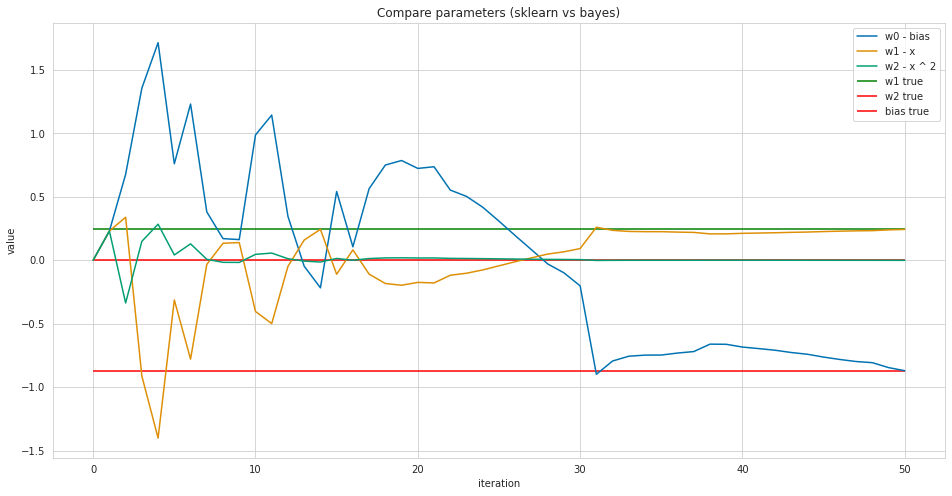

In [50]:
plt.xlabel('iteration')
plt.ylabel('value')
plt.plot(params[0], label='w0 - bias')
plt.plot(params[1], label='w1 - x')
plt.plot(params[2], label='w2 - x ^ 2')

plt.hlines(y=w1, xmin=0, xmax=50, label='w1 true', colors='g')
plt.hlines(y=w2, xmin=0, xmax=50, label='w2 true', color='r')
plt.hlines(y=w0, xmin=0, xmax=50, label='bias true', color='r')
plt.title('Compare parameters (sklearn vs bayes)')

plt.legend();

on the last iteration bayes and sklearn paramters are the same

In [40]:
cur_mu

array([-0.87005656,  0.24261107, -0.00091286])

In [41]:
cur_sigma

array([[ 3.08967855e-01, -2.44685587e-02,  4.03770399e-04],
       [-2.44685587e-02,  2.52987807e-03, -4.66343184e-05],
       [ 4.03770399e-04, -4.66343184e-05,  9.14707635e-07]])

# 3.c

In [42]:
n_weights = 100
weights = np.random.multivariate_normal(cur_mu, cur_sigma, n_weights)

In [43]:
weights[0]

array([0.34044366, 0.14068715, 0.00112124])

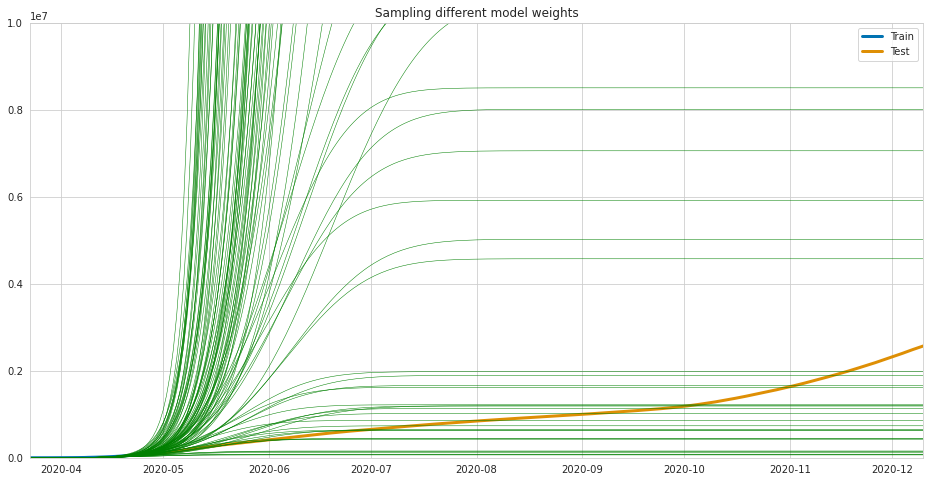

In [44]:
plt.plot(train['date'], train[TARGET], linewidth=3, label='Train')
plt.plot(test['date'], test[TARGET], linewidth=3, label='Test')


n_weights = 100
n_days = 600
weights = np.random.multivariate_normal(cur_mu, cur_sigma, size=n_weights)
X = np.arange(n_days)

preds = []
for w0_, w1_, w2_ in weights:
    pred = np.cumsum(np.exp(X * w1_ + X ** 2 * w2_ + w0_))
    plt.plot(df[:n_days]['date'], pred, color='g', linewidth=0.5)
    preds.append(pred)


plt.xlim(left=datetime.date(2020,3,23), right=datetime.date(2020,12,10))
plt.ylim(bottom=0, top=1e7)

plt.title('Sampling different model weights')
plt.legend()


In [45]:
preds = np.array(preds)

In [46]:
last_vals = preds[:,-1]

In [47]:
bad_news = int(np.percentile(last_vals, 90))
good_news = int(np.percentile(last_vals, 10))

In [51]:
#outlier in bad_news value
print(f'good news: {good_news} total \n\nbad news: {bad_news} total')

good news: 635700 total 

bad news: 178522871154216440839855658212166275479821372720959796332788440664258058406165177957580570086424242420291993600 total


(array([42.,  1.,  0.,  2.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  2.]),
 array([6.69489629e+04, 2.38307100e+08, 4.76547251e+08, 7.14787402e+08,
        9.53027553e+08, 1.19126770e+09, 1.42950786e+09, 1.66774801e+09,
        1.90598816e+09, 2.14422831e+09, 2.38246846e+09, 2.62070861e+09,
        2.85894876e+09, 3.09718891e+09, 3.33542906e+09, 3.57366922e+09,
        3.81190937e+09, 4.05014952e+09, 4.28838967e+09, 4.52662982e+09,
        4.76486997e+09]),
 <BarContainer object of 20 artists>)

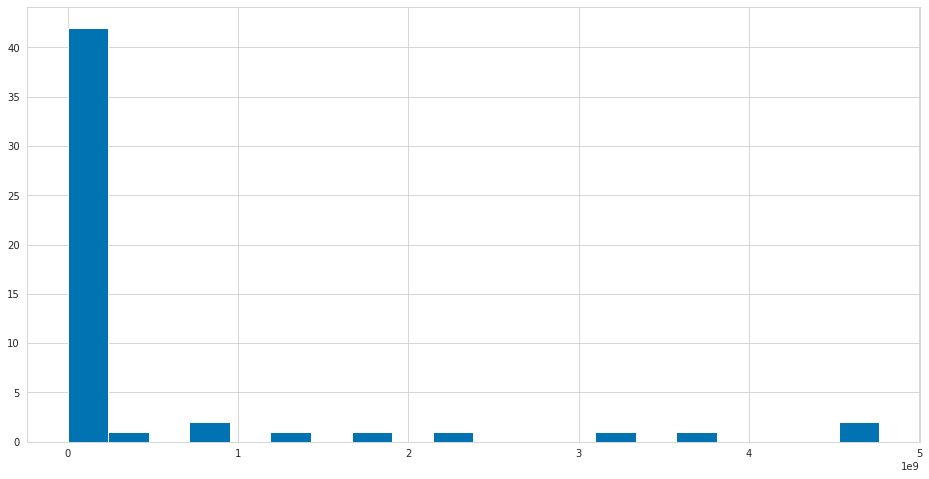

In [49]:
plt.hist(last_vals[last_vals < 1e10], bins=20)

# 5

Подвело моделирование через сигмоиду, не все хорошо "гнулись", как результат есть аномально большие значения, которые портят картину.

